<a href="https://colab.research.google.com/github/GluteusStrength/Machine-Learning-contents/blob/main/AlexNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 필요한 module import
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # 이미지 표준화
trainset = torchvision.datasets.CIFAR10(root = "./data", train = True, download = True, transform = transform) # CIFAR10 데이터 셋 업로드
trainloader = torch.utils.data.DataLoader(trainset, batch_size = 32, shuffle = True) # batch_size = 32

testset = torchvision.datasets.CIFAR10(root = "./data", train = False, download = True, transform = transform)
testloader = torch.utils.data.DataLoader(testset, batch_size = 32, shuffle = False)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
# gpu check
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'{device} is available')

cuda:0 is available


In [4]:
class Model(nn.Module):
  def __init__(self):
    super(Model, self).__init__() # 필수적으로 적어줘야 한다.
    self.conv = nn.Sequential(
        nn.Conv2d(3, 64, 3), # Conv2d의 parameter: in_channels, out_channels, kernel_size 순서
        nn.ReLU(), # activation function
        nn.MaxPool2d(2, 2), # pooling layer
        nn.Conv2d(64, 128, 3, padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),
        nn.Conv2d(128, 256, 3, padding = 1),
        nn.ReLU(),
        nn.Conv2d(256, 512, 3, padding = 1),
        nn.ReLU(),
        nn.Conv2d(512, 224, 1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2)
    )
    self.fc = nn.Sequential(
        # dropout: 과적합 방지용
        nn.Dropout(0.5),
        # conv, pooling 과정을 거치면 28*28*3 -> 3*3*224
        nn.Linear(224*3*3, 1024),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(1024, 512),
        nn.ReLU(),
        nn.Linear(512, 10)
    )
  def forward(self, x):
    x = self.conv(x)
    x = x.view(-1, 224*3*3) # flatten을 시켜준다.
    x = self.fc(x)
    return x

In [5]:
# classification -> loss_function은 CrossEntropyLoss
criterion = nn.CrossEntropyLoss()
model = Model().to(device)
optimizer = optim.Adam(model.parameters(), lr = 1e-3)

In [6]:
loss_ = []
n = len(trainloader)
for epoch in range(50):
  running_loss = 0.0
  for data in trainloader:
    i, l = data[0].to(device), data[1].to(device)
    optimizer.zero_grad()
    outputs = model(i)
    loss = criterion(outputs, l)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
  loss_.append(running_loss / n)
  print("loss: {} epoch, {}".format(epoch, running_loss / len(trainloader)))

loss: 0 epoch, 1.5984628505227814
loss: 1 epoch, 1.1998554632134417
loss: 2 epoch, 1.0283143056827102
loss: 3 epoch, 0.9153092830743991
loss: 4 epoch, 0.8396722368910308
loss: 5 epoch, 0.7769097934452601
loss: 6 epoch, 0.7114609482764283
loss: 7 epoch, 0.6753503278288716
loss: 8 epoch, 0.6455940920919161
loss: 9 epoch, 0.6063518626085094
loss: 10 epoch, 0.5761561608198204
loss: 11 epoch, 0.5510460544456218
loss: 12 epoch, 0.5292450499769136
loss: 13 epoch, 0.4994703571497441
loss: 14 epoch, 0.4868534574724891
loss: 15 epoch, 0.46157687860502317
loss: 16 epoch, 0.4468715228640873
loss: 17 epoch, 0.440945215118061
loss: 18 epoch, 0.41803304766205285
loss: 19 epoch, 0.4097205539182143
loss: 20 epoch, 0.3851438368183828
loss: 21 epoch, 0.3746638998641887
loss: 22 epoch, 0.3670673060945342
loss: 23 epoch, 0.33935630594642974
loss: 24 epoch, 0.35416851360267426
loss: 25 epoch, 0.328236245398272
loss: 26 epoch, 0.32864613348995925
loss: 27 epoch, 0.3306921989783902
loss: 28 epoch, 0.300092250

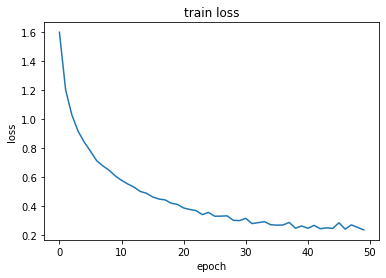

In [7]:
# visualization
plt.plot(loss_)
plt.title("train loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

In [12]:
# assessment
cor = 0
total = 0
with torch.no_grad(): # requries_grad 비활성화
  model.eval() # evaluation시에는 정규화과정 x. 이를 통해 선언한다
  for data in testloader:
    d, l = data[0].to(device), data[1].to(device)
    output = model(d) # batch_size * 10의 matrix
    # torch.max(x, 1): x를 열을 기준으로 최댓값, 최댓값의 index가 나오게 된다
    _, pred = torch.max(output, 1) # 최댓값 자체는 필요없으므로 _로 따로 저장 x
    total += l.size(0) # 총 개수
    cor += (pred == l).sum().item() # 누적: 맞으면 1, 틀리면 0
print("test acc: {}%".format((cor/total)*100))

test acc: 74.98%
